In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import h5py
import numpy as np
import scipy as sp
import scipy.stats as stats
import nibabel as nibabel
import pandas as pd
import nibabel.freesurfer.mghformat as mgh
import scipy.io
import itertools 
import pickle

In [2]:
data_dir = '../../../data/'
local_data_dir = '../../../local_data/'

subjid = ['01', '02', '03', '04', '05', '06', '07', '08']
ROI_names = ['Unknown', 'Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal']
n_repeats = 3

#threshold for voxels (based on split-half reliability)
thresh = 0.2

### Get right hemi data and process

In [4]:
#get ROI data
rh_streams = []
for sidx, sid in enumerate(subjid):
    mgh_file = mgh.load(data_dir+'nsddata/freesurfer/subj'+ sid +'/label/rh.streams.mgz')
    rh_streams.append(mgh_file.get_fdata()[:,0,0])

#get voxel level split-half reliability data
reliability = []
for sidx, sid in enumerate(subjid):
    
    sh_dir = local_data_dir + 'freesurfer/subj' + sid + '/rh_split_half.mat'
    sh = scipy.io.loadmat(sh_dir)
    
    reliability.append(sh['mean'])

#get organized z-scored betas
with open(local_data_dir + 'processed/rh_betas_by_repeat_by_ROI_zscore.data', 'rb') as filehandle:
    # read the data as binary data stream
    rh_betas_by_repeat_by_ROI = pickle.load(filehandle)

In [5]:
# Replace voxels with split-half reliability < thresh with NaNs and then trim those from data structure

sh_by_ROI = [[[] for j in range(len(ROI_names)-1)] for i in range(len(subjid))]
total_vox = np.zeros((len(subjid), len(ROI_names)-1))

#organize
for sidx, sid in enumerate(subjid):  
    for roi_idx in range(len(ROI_names)-1):       
        sh_by_ROI[sidx][roi_idx]=reliability[sidx][:,rh_streams[sidx] == roi_idx+1]
        total_vox[sidx,roi_idx] = len(sh_by_ROI[sidx][roi_idx][0])

#convert to nans
for sidx, sid in enumerate(subjid):  
    for roi_idx in range(len(ROI_names)-1): 
        for vox in range(len(sh_by_ROI[sidx][roi_idx][0])):
            if sh_by_ROI[sidx][roi_idx][0][vox] < thresh:
                rh_betas_by_repeat_by_ROI[sidx][roi_idx][0][:,vox]=np.nan
                rh_betas_by_repeat_by_ROI[sidx][roi_idx][1][:,vox]=np.nan
                rh_betas_by_repeat_by_ROI[sidx][roi_idx][2][:,vox]=np.nan    

thresh_vox = np.zeros((len(subjid), len(ROI_names)-1))                
#trim out nans
for sidx, sid in enumerate(subjid):   
    for roi_idx in range(len(ROI_names)-1): 
        for r in range(n_repeats):
            temp = rh_betas_by_repeat_by_ROI[sidx][roi_idx][r]
            trimmed = temp[:,~np.all(np.isnan(temp), axis=0)]

            rh_betas_by_repeat_by_ROI[sidx][roi_idx][r] = trimmed
        thresh_vox[sidx,roi_idx] = trimmed.shape[1]

#gather number of remaining voxels for each ROI and subj
vox = np.zeros((len(ROI_names)-1, len(subjid)))
for roi_idx in range(len(ROI_names)-1):
    vox[roi_idx,:] = [rh_betas_by_repeat_by_ROI[sidx][roi_idx][0].shape[1] for sidx, sid in enumerate(subjid)] 

In [6]:
# Create RSMS for all the ROIs, repeats and subjects

tril_flat_shape = int((rh_betas_by_repeat_by_ROI[0][0][0].shape[0]**2/2) - (rh_betas_by_repeat_by_ROI[0][0][0].shape[0]/2))
rh_flat_rsm = np.zeros((len(subjid),len(ROI_names)-1, tril_flat_shape, n_repeats))
rsm = np.zeros((len(subjid),len(ROI_names)-1,n_repeats,rh_betas_by_repeat_by_ROI[0][0][0].shape[0],rh_betas_by_repeat_by_ROI[0][0][0].shape[0]))

for sidx, sid in enumerate(subjid):
    
    for roi_idx in range(len(ROI_names)-1):
        voxels = np.min(vox[roi_idx,:])
        
        for r in range(n_repeats):
            rsm[sidx,roi_idx,r,:,:] = np.corrcoef(rh_betas_by_repeat_by_ROI[sidx][roi_idx][r])
            lower = np.tril(rsm[sidx,roi_idx,r,:,:], -1).T.ravel() #only need lower triangle without diagonal
            rh_flat_rsm[sidx, roi_idx, :,r] = lower[lower != 0] #flatten into vectors

### Get left hemi data and process

In [7]:
#get ROI data
lh_streams = []
for sidx, sid in enumerate(subjid):
    mgh_file = mgh.load(data_dir+'nsddata/freesurfer/subj'+ sid +'/label/lh.streams.mgz')
    lh_streams.append(mgh_file.get_fdata()[:,0,0])

#get voxel level split-half reliability data
reliability = []
for sidx, sid in enumerate(subjid):
    
    sh_dir = local_data_dir + 'freesurfer/subj' + sid + '/lh_split_half.mat'
    sh = scipy.io.loadmat(sh_dir)
    
    reliability.append(sh['mean'])

#get organized z-scored betas
with open(local_data_dir + 'processed/lh_betas_by_repeat_by_ROI_zscore.data', 'rb') as filehandle:
    # read the data as binary data stream
    lh_betas_by_repeat_by_ROI = pickle.load(filehandle)

In [8]:
# Replace voxels with split-half reliability < thresh with NaNs and then trim those from data structure

sh_by_ROI = [[[] for j in range(len(ROI_names)-1)] for i in range(len(subjid))]
total_vox = np.zeros((len(subjid), len(ROI_names)-1))

#organize
for sidx, sid in enumerate(subjid):  
    for roi_idx in range(len(ROI_names)-1):       
        sh_by_ROI[sidx][roi_idx]=reliability[sidx][:,lh_streams[sidx] == roi_idx+1]
        total_vox[sidx,roi_idx] = len(sh_by_ROI[sidx][roi_idx][0])

#convert to nans
for sidx, sid in enumerate(subjid):  
    for roi_idx in range(len(ROI_names)-1): 
        for vox in range(len(sh_by_ROI[sidx][roi_idx][0])):
            if sh_by_ROI[sidx][roi_idx][0][vox] < thresh:
                lh_betas_by_repeat_by_ROI[sidx][roi_idx][0][:,vox]=np.nan
                lh_betas_by_repeat_by_ROI[sidx][roi_idx][1][:,vox]=np.nan
                lh_betas_by_repeat_by_ROI[sidx][roi_idx][2][:,vox]=np.nan    

                thresh_vox = np.zeros((len(subjid), len(ROI_names)-1))
                
#trim out nans
for sidx, sid in enumerate(subjid):   
    for roi_idx in range(len(ROI_names)-1): 
        for r in range(n_repeats):
            temp = lh_betas_by_repeat_by_ROI[sidx][roi_idx][r]
            trimmed = temp[:,~np.all(np.isnan(temp), axis=0)]

            lh_betas_by_repeat_by_ROI[sidx][roi_idx][r] = trimmed
        thresh_vox[sidx,roi_idx] = trimmed.shape[1]

#gather number of remaining voxels for each ROI and subj
vox = np.zeros((len(ROI_names)-1, len(subjid)))
for roi_idx in range(len(ROI_names)-1):
    vox[roi_idx,:] = [lh_betas_by_repeat_by_ROI[sidx][roi_idx][0].shape[1] for sidx, sid in enumerate(subjid)]        

In [9]:
# Create RSMS for all the ROIs, repeats and subjects

tril_flat_shape = int((lh_betas_by_repeat_by_ROI[0][0][0].shape[0]**2/2) - (lh_betas_by_repeat_by_ROI[0][0][0].shape[0]/2))
lh_flat_rsm = np.zeros((len(subjid),len(ROI_names)-1, tril_flat_shape, n_repeats))
rsm = np.zeros((len(subjid),len(ROI_names)-1,n_repeats,lh_betas_by_repeat_by_ROI[0][0][0].shape[0],lh_betas_by_repeat_by_ROI[0][0][0].shape[0]))

for sidx, sid in enumerate(subjid):
    
    for roi_idx in range(len(ROI_names)-1):
        voxels = np.min(vox[roi_idx,:])
        
        for r in range(n_repeats):
            rsm[sidx,roi_idx,r,:,:] = np.corrcoef(lh_betas_by_repeat_by_ROI[sidx][roi_idx][r])
            lower = np.tril(rsm[sidx,roi_idx,r,:,:], -1).T.ravel() #only need lower triangle without diagonal
            lh_flat_rsm[sidx, roi_idx, :,r] = lower[lower != 0] #flatten into vectors

## Compare hemispheres

In [10]:
r1_trial_order = [0, 0, 0, 1, 1, 1, 2, 2, 2]
r2_trial_order = [0, 1, 2, 0, 1, 2, 0, 1, 2]

#don't use same trials when same subject
ss_r1_trial_order = [0, 0, 1, 1, 2, 2]
ss_r2_trial_order = [1, 2, 0, 2, 0, 1]

In [12]:
total_combs = len(subjid) * (len(ROI_names)-1)
mega_matrix = np.zeros((total_combs,total_combs))

for i in range(total_combs): #rows - i.e. model candidate
    roi_idx1 = i%7 #roi
    sidx1 = i//7 #subject
    
    split_half = np.zeros((3))
    split_half = [np.absolute(stats.pearsonr(rh_flat_rsm[sidx1,roi_idx1,:,0],rh_flat_rsm[sidx1,roi_idx1,:,1])[0]),
                  np.absolute(stats.pearsonr(rh_flat_rsm[sidx1,roi_idx1,:,0],rh_flat_rsm[sidx1,roi_idx1,:,2])[0]),
                  np.absolute(stats.pearsonr(rh_flat_rsm[sidx1,roi_idx1,:,1],rh_flat_rsm[sidx1,roi_idx1,:,2])[0])]
    NC_model = np.mean(split_half) * 100
    
    for j in range(total_combs): #columns - i.e. target data
        roi_idx2 = j%7 #roi
        sidx2 = j//7 #subject
        
        split_half = np.zeros((3))
        split_half = [np.absolute(stats.pearsonr(lh_flat_rsm[sidx2,roi_idx2,:,0],lh_flat_rsm[sidx2,roi_idx2,:,1])[0]),
                      np.absolute(stats.pearsonr(lh_flat_rsm[sidx2,roi_idx2,:,0],lh_flat_rsm[sidx2,roi_idx2,:,2])[0]),
                      np.absolute(stats.pearsonr(lh_flat_rsm[sidx2,roi_idx2,:,1],lh_flat_rsm[sidx2,roi_idx2,:,2])[0])]
        NC_target = np.mean(split_half) * 100
        
        if (sidx1 == sidx2): #within subject
            rsm_corr = np.zeros((6))
            for r in range(6):
                rsm_corr[r] = np.absolute(stats.pearsonr(rh_flat_rsm[sidx1,roi_idx1,:,ss_r1_trial_order[r]],
                                                         lh_flat_rsm[sidx2,roi_idx2,:,ss_r2_trial_order[r]])[0])
            mega_matrix[i,j] = np.mean(rsm_corr) * np.sqrt(100/NC_model) * np.sqrt(100/NC_target)
        else: #between subject
            rsm_corr = np.zeros((9))
            for r in range(9):
                rsm_corr[r] = np.absolute(stats.pearsonr(rh_flat_rsm[sidx1,roi_idx1,:,r1_trial_order[r]],
                                                         lh_flat_rsm[sidx2,roi_idx2,:,r2_trial_order[r]])[0])
            mega_matrix[i,j] = np.mean(rsm_corr) * np.sqrt(100/NC_model) * np.sqrt(100/NC_target)
        

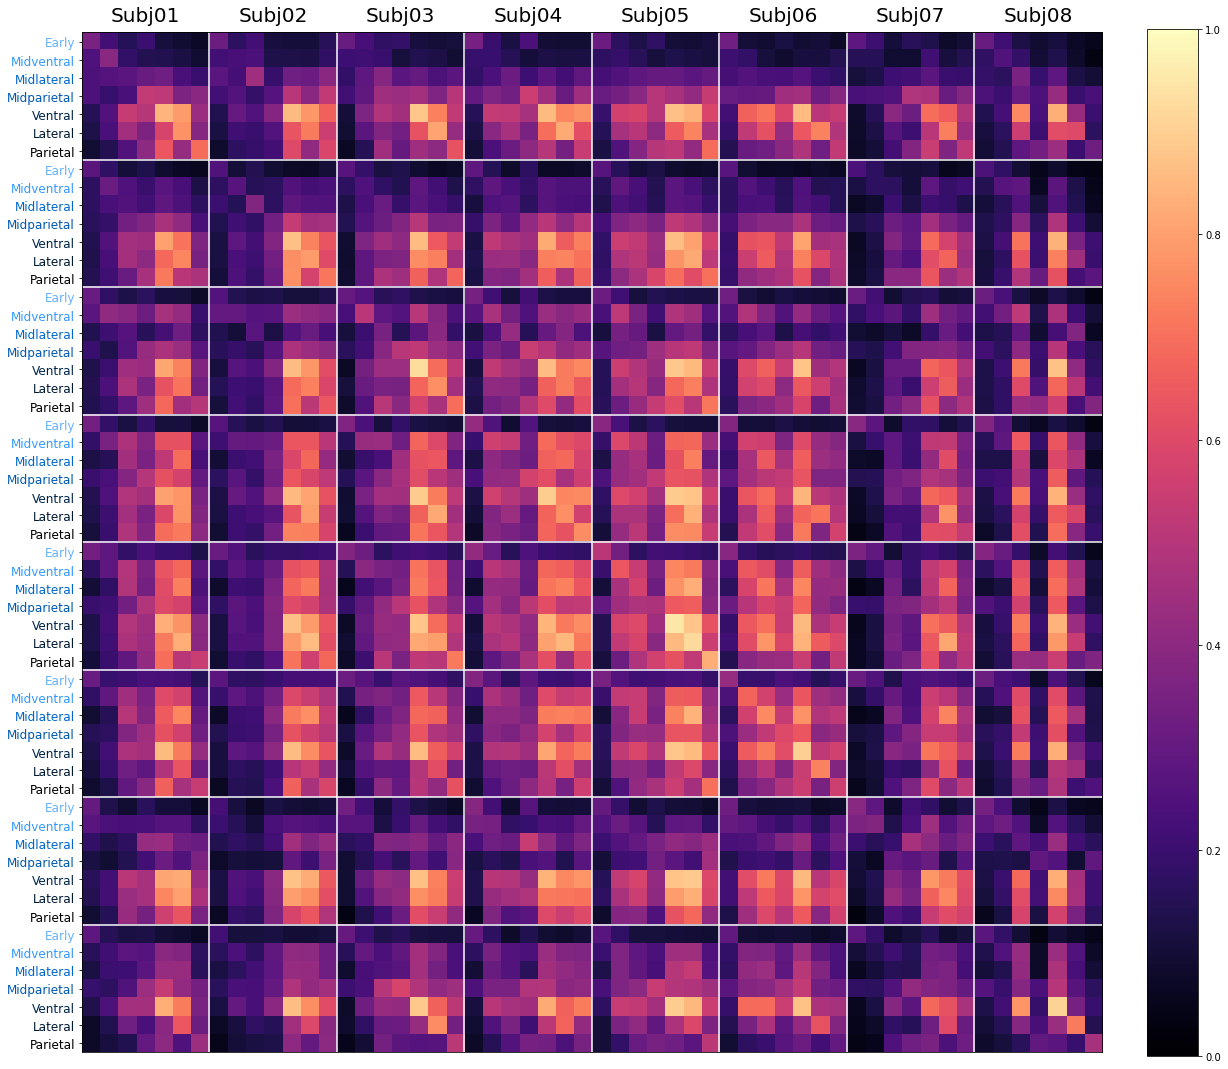

In [31]:
plt.figure(figsize=(20, 20))
plt.imshow(mega_matrix,
           cmap='magma')

x_labels = ['Subj01', 'Subj02', 'Subj03', 'Subj04', 'Subj05', 'Subj06', 'Subj07', 'Subj08']
y_labels = ['Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal']

x_ticks = np.arange(0+3, 56+3,7)
plt.xticks(x_ticks, x_labels, fontsize=20)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)

y_ticks = np.arange(0, 56)
plt.yticks(y_ticks, np.tile(y_labels, 8), fontsize='large')
colors = ['#66b3ff','#3399ff','#0066cc','#0059b3','#00264d','#001a33','#000000']
for i in range(56):
    r = i%7
    plt.gca().get_yticklabels()[i].set_color(colors[r])

plt.axvline(x=6.5, c='w')
plt.axvline(x=13.5, c='w')
plt.axvline(x=20.5, c='w')
plt.axvline(x=27.5, c='w')
plt.axvline(x=34.5, c='w')
plt.axvline(x=41.5, c='w')
plt.axvline(x=48.5, c='w')


plt.axhline(y=6.5, c='w')
plt.axhline(y=13.5, c='w')
plt.axhline(y=20.5, c='w')
plt.axhline(y=27.5, c='w')
plt.axhline(y=34.5, c='w')
plt.axhline(y=41.5, c='w')
plt.axhline(y=48.5, c='w')

plt.clim(0,1)
plt.colorbar(fraction=0.046, pad=0.04)

plt.savefig('../../../results/figures/megaMatrix_voxThresh' + str(int(thresh*100)) + '_adjusted_hemi_comp.png')
